# MVP Reranking

This notebook explores the second component: Ranking

# Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import mlflow
from datetime import datetime
from datetime import timedelta
from dotenv import load_dotenv
from loguru import logger
from typing import List
from tqdm.notebook import tqdm

from pydantic import BaseModel
import datasets
from datasets import load_dataset

import pandas as pd

datasets.logging.set_verbosity_error()

load_dotenv()
sys.path.insert(0, '..')

# Set up plot styling
from src.utils.time import log_time
from src.visualization.setup import color_scheme, fsds_colors

# Controller

In [3]:
class Args(BaseModel):
    testing: bool = False
    log_to_mlflow: bool = True
    experiment_name: str = "FSDS RecSys - L3 - MVP"
    run_name: str = '002-ranking-first-attempt'
    hf_dataset_path: str = "McAuley-Lab/Amazon-Reviews-2023"
    notebook_persist_dp: str = None
    random_seed: int = 41

    train_num_days: int = 90
    val_num_days: int = 7
    test_num_days: int = 7
    fit_num_days: int = None

    batch_size: int = 1024

    def init(self):
        self.notebook_persist_dp = os.path.abspath(f"data/{self.run_name}")

        if self.testing:
            logger.info("testing=True so downsampling the data...")
            self.train_num_days = 7
            self.val_num_days = 1
            self.test_num_days = 1

        self.fit_num_days = self.train_num_days + self.val_num_days + self.test_num_days
        
        if not os.environ.get("MLFLOW_TRACKING_URI"):
            logger.warning(
                f"Environment variable MLFLOW_TRACKING_URI is not set. Setting self.log_to_mlflow to false."
            )
            self.log_to_mlflow = False

        if self.log_to_mlflow:
            logger.info(
                f"Setting up MLflow experiment {self.experiment_name} - run {self.run_name}..."
            )
            import mlflow

            mlflow.set_experiment(self.experiment_name)
            mlflow.start_run(run_name=self.run_name)

        return self
    
args = Args().init()

print(args.model_dump_json(indent=2))

2024-09-01 09:28:43.058 | INFO     | __main__:init:35 - Setting up MLflow experiment FSDS RecSys - L3 - MVP - run 002-ranking-first-attempt...


{
  "testing": false,
  "log_to_mlflow": true,
  "experiment_name": "FSDS RecSys - L3 - MVP",
  "run_name": "002-ranking-first-attempt",
  "hf_dataset_path": "McAuley-Lab/Amazon-Reviews-2023",
  "notebook_persist_dp": "/home/dvquys/frostmourne/fsds/recsys/notebooks/data/002-ranking-first-attempt",
  "random_seed": 41,
  "train_num_days": 90,
  "val_num_days": 7,
  "test_num_days": 7,
  "fit_num_days": 104,
  "batch_size": 1024
}


# Load data

In [4]:
metadata = load_dataset(args.hf_dataset_path, name="raw_meta_Video_Games", split="full", trust_remote_code=True)

In [5]:
metadata[0]

{'main_category': 'Video Games',
 'title': 'Dash 8-300 Professional Add-On',
 'average_rating': 5.0,
 'rating_number': 1,
 'features': ["Features Dash 8-300 and 8-Q300 ('Q' rollout livery)",
  'Airlines - US Airways, South African Express, Bahamasair, Augsburg Airways, Lufthansa Cityline, British Airways (Union Jack), British European, FlyBe, Intersky, Wideroe, Iberia, Tyrolean, QantasLink, BWIA',
  'Airports include - London City, Frankfurt, Milan and Amsterdam Schipol',
  'Includes PSS PanelConfig and LoadEdit tools'],
 'description': ['The Dash 8-300 Professional Add-On lets you pilot a real commuter special. Fly two versions of the popular Dash 8-300 in a total of 17 different liveries. The Dash 8-300 is one of the most popular short-haul aircraft available and this superbly modelled version from acclaimed aircraft developers PSS is modelled in two versions with a total of 17 different liveries. The package also includes scenery for three European airports, tutorials, tutorial flig

In [6]:
dataset = load_dataset(args.hf_dataset_path, name="0core_rating_only_Video_Games", trust_remote_code=True)
# To load all user review data such as review_text, helpful score, use: name="raw_review_All_Beauty"

In [7]:
dataset

DatasetDict({
    full: Dataset({
        features: ['user_id', 'parent_asin', 'rating', 'timestamp'],
        num_rows: 4555500
    })
})

In [8]:
dataset['full'][0]

{'user_id': 'AGCI7FAH4GL5FI65HYLKWTMFZ2CQ',
 'parent_asin': 'B07SRWRH5D',
 'rating': '5.0',
 'timestamp': '1587051114941'}

In [9]:
metadata[0]

{'main_category': 'Video Games',
 'title': 'Dash 8-300 Professional Add-On',
 'average_rating': 5.0,
 'rating_number': 1,
 'features': ["Features Dash 8-300 and 8-Q300 ('Q' rollout livery)",
  'Airlines - US Airways, South African Express, Bahamasair, Augsburg Airways, Lufthansa Cityline, British Airways (Union Jack), British European, FlyBe, Intersky, Wideroe, Iberia, Tyrolean, QantasLink, BWIA',
  'Airports include - London City, Frankfurt, Milan and Amsterdam Schipol',
  'Includes PSS PanelConfig and LoadEdit tools'],
 'description': ['The Dash 8-300 Professional Add-On lets you pilot a real commuter special. Fly two versions of the popular Dash 8-300 in a total of 17 different liveries. The Dash 8-300 is one of the most popular short-haul aircraft available and this superbly modelled version from acclaimed aircraft developers PSS is modelled in two versions with a total of 17 different liveries. The package also includes scenery for three European airports, tutorials, tutorial flig

# Split train-val-test
We would split the dataset by absolute timestamp, leaving 7 days of data in our validation and 7 days of data in our test set. This splitting strategy mimics the production environment where our models are trained to predict on future data. Even though in practice we may retrain model everyday, we hold out 7 days of data to account for the fact that choosing one day data as validation have a high risk of not representing the true populations since there might be special events on that day.

In [10]:
raw_df = dataset['full'].to_pandas()

In [11]:
raw_df

,user_id,parent_asin,rating,timestamp
0,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B07SRWRH5D,5.0,1587051114941
1,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B07DK1H3H5,4.0,1608186804795
2,AGXVBIUFLFGMVLATYXHJYL4A5Q7Q,B07MFMFW34,5.0,1490877431000
3,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,B00HUWA45W,5.0,1427591932000
4,AFTC6ZR5IKNRDG5JCPVNVMU3XV2Q,B0BCHWZX95,5.0,1577637634017
...,...,...,...,...
4555495,AEGJO3XG3JGBVIJW64SDJ6BIYWHQ,B0C89J78ZW,5.0,1694315538121
4555496,AHTYCU6NSHJ4BY7R2YNDIDGUXS6Q,B089F1BD4W,5.0,1600863891023
4555497,AF4KDWDGCJSUEB7JESQZ6ZWD2LNA,B0BN942894,5.0,1584887999168
4555498,AG3BHCQJCY3MPNP3UKVAENSGQM2A,B09SM83KRP,1.0,1666690302530


In [12]:
metadata_raw_df = metadata.to_pandas()

In [13]:
metadata_raw_df

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Video Games,Dash 8-300 Professional Add-On,5.0,1,[Features Dash 8-300 and 8-Q300 ('Q' rollout l...,[The Dash 8-300 Professional Add-On lets you p...,None,"{'hi_res': [None], 'large': ['https://m.media-...","{'title': [], 'url': [], 'user_id': []}",Aerosoft,"[Video Games, PC, Games]","{""Pricing"": ""The strikethrough price is the Li...",B000FH0MHO,None,None,None
1,Video Games,Phantasmagoria: A Puzzle of Flesh,4.1,18,[Windows 95],[],None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Sierra,"[Video Games, PC, Games]","{""Best Sellers Rank"": {""Video Games"": 137612, ...",B00069EVOG,None,None,None
2,Video Games,NBA 2K17 - Early Tip Off Edition - PlayStation 4,4.3,223,[The #1 rated NBA video game simulation series...,[Following the record-breaking launch of NBA 2...,58.0,{'hi_res': ['https://m.media-amazon.com/images...,{'title': ['NBA 2K17 - Kobe: Haters vs Players...,2K,"[Video Games, PlayStation 4, Games]","{""Release date"": ""September 16, 2016"", ""Best S...",B00Z9TLVK0,None,None,None
3,Video Games,Nintendo Selects: The Legend of Zelda Ocarina ...,4.9,22,[Authentic Nintendo Selects: The Legend of Zel...,[],37.42,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Amazon Renewed,"[Video Games, Legacy Systems, Nintendo Systems...","{""Best Sellers Rank"": {""Video Games"": 51019, ""...",B07SZJZV88,None,None,None
4,Video Games,Thrustmaster Elite Fitness Pack for Nintendo Wii,3.0,3,"[Includes (9) Total Accessories, Pedometer, Wi...",[The Thrustmaster Motion Plus Elite Fitness Pa...,None,"{'hi_res': [None, None, None, None, None, None...","{'title': [], 'url': [], 'user_id': []}",THRUSTMASTER,"[Video Games, Legacy Systems, Nintendo Systems...","{""Release date"": ""November 1, 2009"", ""Pricing""...",B002WH4ZJG,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137264,None,Story of Seasons: Pioneers Of Olive Town (Nint...,4.5,397,[A wild world of discovery - tame the wilderne...,"[Product Description, Inspired by Tales of you...",31.04,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Marvelous Europe,"[Video Games, Nintendo Switch, Games]","{""Release date"": ""March 26, 2021"", ""Best Selle...",B09XQJS4CZ,None,None,None
137265,Video Games,MotoGP 18 (PC DVD) UK IMPORT REGION FREE,4.0,1,[Brand new game engine - MotoGP18 has been reb...,[Become the champion of the 2018 MotoGP Season...,None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Milestone,"[Video Games, Game Genre of the Month]","{""Pricing"": ""The strikethrough price is the Li...",B07DGPTGNV,None,None,None
137266,Cell Phones & Accessories,Century Accessory Soft Silicone Protective Ski...,2.9,19,"[Easy access to all buttons, controls and port...",[This soft case cover will add a splash of col...,None,{'hi_res': ['https://m.media-amazon.com/images...,"{'title': [], 'url': [], 'user_id': []}",Century Accessory,"[Video Games, Legacy Systems, Xbox Systems, Xb...","{""Package Dimensions"": ""2.76 x 2.76 x 0.2 inch...",B00HUWCQBW,None,None,None
137267,None,Hasbro Interactive Mr. Potato Head Activity Pa...,3.9,5,[],"[Amazon.com, Everyone's favorite master-of-dis...",None,"{'hi_res': [None, 'https://m.media-amazon.com/...","{'title': [], 'url': [], 'user_id': []}",Hasbro,"[Video Games, PC, Games]","{""Release date"": ""July 24, 1999"", ""Best Seller...",B00002S9MH,None,None,None


## Select the period for modeling

In [14]:
import plotly.express as px

from src.utils.data_prep import parse_dt, handle_dtypes

In [15]:
raw_df = (
    raw_df
    .pipe(parse_dt)
    .pipe(handle_dtypes)
)

In [16]:
max_date = datetime.strptime("2023-01-07", "%Y-%m-%d")
fit_min_date = max_date - timedelta(days=args.fit_num_days)

In [17]:
fit_df = raw_df.loc[lambda df: df['timestamp'].between(fit_min_date, max_date)]

In [18]:
fit_df.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
user_id,121672,95541,AF3T3YI4DGABBU3CNRW2UASWCOMA,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parent_asin,121672,20949,B07V8YSBFG,1166,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,121672.0,NaN,NaN,NaN,3.932803,1.0,3.0,5.0,5.0,5.0,1.512106
timestamp,121672,NaN,NaN,NaN,2022-11-20 12:38:56.630720768,2022-09-25 00:00:33.663000,2022-10-25 02:26:30.932000,2022-11-22 01:36:38.600999936,2022-12-18 01:48:24.887749888,2023-01-06 23:59:42.997000,NaN


## Split

In [19]:
from src.features.split import train_test_split_timebased

In [20]:
train_df, val_df, test_df = train_test_split_timebased(fit_df, args)

2024-09-01 09:28:57.674 | INFO     | src.features.split.timebased:train_test_split_timebased:28 - Removing the new users in val and test sets...
2024-09-01 09:28:57.713 | INFO     | src.features.split.timebased:train_test_split_timebased:34 - Removed 8950 users from val set
2024-09-01 09:28:57.714 | INFO     | src.features.split.timebased:train_test_split_timebased:37 - Removed 10969 users from test set


# Load into PyTorch dataset

We will build a model to predict the rating for a pair of user-item by utilizing only the user_id and item_id

In [21]:
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class PandasDataset(Dataset):
    def __init__(self, df: pd.DataFrame, label_col: str, feature_cols: List[str]):
        self.df = df
        self.label_col = label_col
        self.feature_cols = feature_cols

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        label = self.df.iloc[idx][self.label_col]
        features = self.df.iloc[idx][self.feature_cols]
        return {
            "user_ids": features.values[0],
            "item_ids": features.values[1],
            "label": torch.as_tensor(label, dtype=torch.float32)
        }

train_dataloader = DataLoader(PandasDataset(train_df, label_col='rating', feature_cols=['user_id', 'parent_asin']), batch_size=args.batch_size)
val_dataloader = DataLoader(PandasDataset(val_df, label_col='rating', feature_cols=['user_id', 'parent_asin']), batch_size=args.batch_size)

for data_json in train_dataloader:
    print(data_json)
    break

{'user_ids': ['AH3ACQ7TBS7IT4SRSWEYLLJ3ND3Q', 'AH67BI7JTOFR35HMZYFVOEHM4CPQ', 'AH67BI7JTOFR35HMZYFVOEHM4CPQ', 'AHBI5SLZDP3Q3LZPETJLCHQFGLUA', 'AHBI5SLZDP3Q3LZPETJLCHQFGLUA', 'AHBI5SLZDP3Q3LZPETJLCHQFGLUA', 'AG7JSIKUQPSL5AAPRDRKDNWM4U2A', 'AHUPTBY3F3UN2S5H7K5JLP6MAV5Q', 'AHUPTBY3F3UN2S5H7K5JLP6MAV5Q', 'AHUPTBY3F3UN2S5H7K5JLP6MAV5Q', 'AHUPTBY3F3UN2S5H7K5JLP6MAV5Q', 'AHHFW36BP4VMQWC6V2NTKIXFAA2A', 'AEIPJBAN7A55Q5DFFPZSR2UV3OKA', 'AHZOJQDTMJ6WIHY2RV7PB6K5TG7Q', 'AHZOJQDTMJ6WIHY2RV7PB6K5TG7Q', 'AHZOJQDTMJ6WIHY2RV7PB6K5TG7Q', 'AGEFLX2M37K7NSODGTH4XTOFNCVA', 'AET5VFNIYKIHIPO3ZALZSLXX3KOQ', 'AF76P2AWQWB7ZDCNGZO2GV7JIK4Q', 'AFOEUN2ZGL4ZAY43DYHRF6SENVWA', 'AEUAL3EJKUSTNB4YY6STLYGTJALA', 'AEUAL3EJKUSTNB4YY6STLYGTJALA', 'AEUAL3EJKUSTNB4YY6STLYGTJALA', 'AEUAL3EJKUSTNB4YY6STLYGTJALA', 'AF4WLLHTQLRPEZ33OJDYG23MFLKQ', 'AED5VKZVSF7PC3TOET3PKBA5J2JA', 'AHBSL5FBY72KB63INTSP3SNGMFBQ', 'AHBSL5FBY72KB63INTSP3SNGMFBQ', 'AEBEJ6DXXVSLCXD6NJ4XPVWRYDNA', 'AHXOCRWNKC552ESFF3L32W4FJTLA', 'AGXFNB4LAEFSU3XCAJPZWQDUT

# Create the model

In [22]:
from src.features.embedding_id_mapper import IDMapper

In [23]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
logger.info(f"Using {device} device")

2024-09-01 09:28:59.030 | INFO     | __main__:<module>:8 - Using cuda device


In [24]:
class CrossEncoderReranker(nn.Module):
    def __init__(self, user_vocab_size, item_vocab_size, embedding_dim, hidden_dim, device):
        super(CrossEncoderReranker, self).__init__()
        self.user_embedding = nn.Embedding(user_vocab_size, embedding_dim)
        self.item_embedding = nn.Embedding(item_vocab_size, embedding_dim)
        self.fc1 = nn.Linear(2 * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.relu = nn.ReLU()
        self.id_mapper = IDMapper()
        self.device = device

    def forward(self, user_ids, item_ids):
        """
        Forward pass of the model.
        Accepts original user_ids and item_ids as lists, NumPy arrays, Torch tensors, or individual items.
        Converts them to indices.
        """
        if isinstance(user_ids, (str, int)):
            user_ids = [user_ids]
        if isinstance(item_ids, (str, int)):
            item_ids = [item_ids]
        
        if isinstance(user_ids, np.ndarray):
            user_ids = user_ids.tolist()
        if isinstance(item_ids, np.ndarray):
            item_ids = item_ids.tolist()
        
        if isinstance(user_ids, list):
            user_indices = [self.id_mapper.get_user_index(user_id) for user_id in user_ids]
            user_ids = torch.tensor(user_indices)
        elif isinstance(user_ids, torch.Tensor):
            user_indices = [self.id_mapper.get_user_index(user_id.item()) for user_id in user_ids]
            user_ids = torch.tensor(user_indices)
        
        if isinstance(item_ids, list):
            item_indices = [self.id_mapper.get_item_index(item_id) for item_id in item_ids]
            item_ids = torch.tensor(item_indices)
        elif isinstance(item_ids, torch.Tensor):
            item_indices = [self.id_mapper.get_item_index(item_id.item()) for item_id in item_ids]
            item_ids = torch.tensor(item_indices)
        
        user_emb = self.user_embedding(user_ids.to(self.device))
        item_emb = self.item_embedding(item_ids.to(self.device))
        concat_emb = torch.cat([user_emb, item_emb], dim=1)
        x = self.fc1(concat_emb)
        x = self.relu(x)
        x = self.fc2(x)
        return x.squeeze()

    def fit_mapper(self, user_ids, item_ids):
        """
        Fit the IDMapper with the given user_ids and item_ids.
        """
        self.id_mapper.fit(user_ids, item_ids)

    def save(self, model_filepath, mapper_filepath):
        """
        Save the model state and IDMapper to the specified file paths.
        """
        torch.save(self.state_dict(), model_filepath)
        self.id_mapper.save(mapper_filepath)

    def load(self, model_filepath, mapper_filepath):
        """
        Load the model state and IDMapper from the specified file paths.
        """
        self.load_state_dict(torch.load(model_filepath, weights_only=True))
        self.id_mapper.load(mapper_filepath)

    def predict(self, user_ids, item_ids):
        """
        Predict the rating for the given original user_ids and item_ids.
        Accepts individual user_id and item_id or batches of user_ids and item_ids.
        """
        if isinstance(user_ids, (str, int)):
            user_ids = [user_ids]
        if isinstance(item_ids, (str, int)):
            item_ids = [item_ids]
        
        if isinstance(user_ids, np.ndarray):
            user_ids = user_ids.tolist()
        if isinstance(item_ids, np.ndarray):
            item_ids = item_ids.tolist()
        
        ratings = self.forward(user_ids, item_ids)
        return ratings.tolist()
        # return ratings.tolist() if len(ratings.shape) > 0 else ratings.item()

    def recover_ids(self, user_index, item_index):
        """
        Recover the original user_id and item_id from the given indices.
        """
        user_id = self.id_mapper.get_user_id(user_index)
        item_id = self.id_mapper.get_item_id(item_index)
        return user_id, item_id

# Test the model working
user_ids = ['211', '212', '213']
item_ids = ['itemA', 'itemB', 'itemC']

user_vocab_size = len(user_ids) + 1  # +1 for unknown user
item_vocab_size = len(item_ids) + 1  # +1 for unknown item
embedding_dim = 64
hidden_dim = 32

model = CrossEncoderReranker(user_vocab_size, item_vocab_size, embedding_dim, hidden_dim, device).to(device)

# Fit the mapper
model.fit_mapper(user_ids, item_ids)

model_dir = f"{args.notebook_persist_dp}/model"
os.makedirs(model_dir, exist_ok=True)

model.save(f"{model_dir}/model.pth", f'{model_dir}/mapper.json')
model.load(f"{model_dir}/model.pth", f'{model_dir}/mapper.json')

# Predict rating
user_id = '212'
item_id = 'itemA'
rating = model.predict(user_id, item_id)
print(f"Rating for user '{user_id}' and item '{item_id}': {rating}")

# Recover original IDs
user_index = model.id_mapper.get_user_index(user_id)
item_index = model.id_mapper.get_item_index(item_id)
recovered_user_id, recovered_item_id = model.recover_ids(user_index, item_index)
print(f"Recovered User ID: {recovered_user_id}")
print(f"Recovered Item ID: {recovered_item_id}")

Rating for user '212' and item 'itemA': 0.23656590282917023
Recovered User ID: 212
Recovered Item ID: itemA


In [25]:
user_ids_original = train_df['user_id'].unique()
item_ids_original = train_df['parent_asin'].unique()

user_vocab_size = len(user_ids_original) + 1  # +1 for unknown user
item_vocab_size = len(item_ids_original) + 1  # +1 for unknown item
embedding_dim = 64
hidden_dim = 32

model = CrossEncoderReranker(user_vocab_size, item_vocab_size, embedding_dim, hidden_dim, device).to(device)

model.fit_mapper(user_ids_original, item_ids_original)

# Train

In [26]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [27]:
class TrainingArgs(BaseModel):
    num_epochs: int = 50
    patience: int = 3  # Number of epochs to wait for improvement
    improvement_threshold: float = 0.99

train_args = TrainingArgs()

In [28]:
global_step = 0
best_val_loss: float = float('inf')
epochs_without_improvement: int = 0

for epoch in tqdm(range(train_args.num_epochs), desc="Epochs"):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    batch_iterator = tqdm(train_dataloader, desc="Batches", leave=False)
    for step, row in enumerate(batch_iterator):
        optimizer.zero_grad()  # Zero the gradients
        
        # Forward pass
        user_ids = row['user_ids']
        item_ids = row['item_ids']
        label = row['label'].to(device)
        outputs = model(user_ids, item_ids)

        # Compute the loss
        loss = loss_fn(outputs, label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Log every 100 steps
        if global_step % 100 == 0:
            avg_loss = running_loss / (step + 1)
            logger.info(f"Epoch [{epoch+1}/{train_args.num_epochs}], Global Step [{global_step}], Loss: {avg_loss:.4f}")
            if args.log_to_mlflow:
                mlflow.log_metric("loss", avg_loss, step=global_step)

        global_step += 1
        
        # Update the batch progress bar with the current loss
        batch_iterator.set_postfix(loss=running_loss / (step + 1))
        
    # Update the epoch progress bar with the average loss for the epoch
    avg_epoch_loss = running_loss / len(train_dataloader)
    tqdm.write(f"Epoch [{epoch+1}/{train_args.num_epochs}], Loss: {avg_epoch_loss:.4f}")
    logger.info(f"Epoch [{epoch+1}/{train_args.num_epochs}] completed with average loss: {avg_epoch_loss:.4f}")
    if args.log_to_mlflow:
        mlflow.log_metric("epoch_loss", avg_epoch_loss, step=epoch)
    
    # Evaluation on validation dataset
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    with torch.no_grad():  # Disable gradient computation
        for val_row in val_dataloader:
            user_ids = val_row['user_ids']
            item_ids = val_row['item_ids']
            label = val_row['label'].to(device)
            outputs = model(user_ids, item_ids)
            
            # Compute the loss
            val_loss = loss_fn(outputs, label)
            val_running_loss += val_loss.item()
    
    avg_val_loss = val_running_loss / len(val_dataloader)
    tqdm.write(f"Epoch [{epoch+1}/{train_args.num_epochs}], Validation Loss: {avg_val_loss:.4f}")
    logger.info(f"Epoch [{epoch+1}/{train_args.num_epochs}] completed with validation loss: {avg_val_loss:.4f}")
    if args.log_to_mlflow:
        mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
    
    # Early stopping check
    if avg_val_loss < train_args.improvement_threshold * best_val_loss:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= train_args.patience:
            tqdm.write(f"Early stopping triggered after {epoch+1} epochs.")
            logger.info(f"Early stopping triggered after {epoch+1} epochs.")
            break

model_dir = f"{args.notebook_persist_dp}/model"
os.makedirs(model_dir, exist_ok=True)
model.save(f"{model_dir}/model.pth", f'{model_dir}/mapper.json')

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:29:00.217 | INFO     | __main__:<module>:31 - Epoch [1/50], Global Step [0], Loss: 19.0114
2024-09-01 09:29:19.845 | INFO     | __main__:<module>:43 - Epoch [1/50] completed with average loss: 11.3129


Epoch [1/50], Loss: 11.3129


2024-09-01 09:29:20.105 | INFO     | __main__:<module>:63 - Epoch [1/50] completed with validation loss: 5.9848


Epoch [1/50], Validation Loss: 5.9848


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:29:21.407 | INFO     | __main__:<module>:31 - Epoch [2/50], Global Step [100], Loss: 5.6770
2024-09-01 09:29:39.631 | INFO     | __main__:<module>:43 - Epoch [2/50] completed with average loss: 3.6238


Epoch [2/50], Loss: 3.6238


2024-09-01 09:29:39.890 | INFO     | __main__:<module>:63 - Epoch [2/50] completed with validation loss: 2.3296


Epoch [2/50], Validation Loss: 2.3296


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:29:42.223 | INFO     | __main__:<module>:31 - Epoch [3/50], Global Step [200], Loss: 2.3313
2024-09-01 09:29:59.462 | INFO     | __main__:<module>:43 - Epoch [3/50] completed with average loss: 2.4272


Epoch [3/50], Loss: 2.4272


2024-09-01 09:29:59.717 | INFO     | __main__:<module>:63 - Epoch [3/50] completed with validation loss: 2.1125


Epoch [3/50], Validation Loss: 2.1125


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:30:03.009 | INFO     | __main__:<module>:31 - Epoch [4/50], Global Step [300], Loss: 2.0281
2024-09-01 09:30:19.292 | INFO     | __main__:<module>:43 - Epoch [4/50] completed with average loss: 2.2152


Epoch [4/50], Loss: 2.2152


2024-09-01 09:30:19.545 | INFO     | __main__:<module>:63 - Epoch [4/50] completed with validation loss: 2.0611


Epoch [4/50], Validation Loss: 2.0611


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:30:23.953 | INFO     | __main__:<module>:31 - Epoch [5/50], Global Step [400], Loss: 1.8866
2024-09-01 09:30:38.845 | INFO     | __main__:<module>:43 - Epoch [5/50] completed with average loss: 2.0636


Epoch [5/50], Loss: 2.0636


2024-09-01 09:30:39.100 | INFO     | __main__:<module>:63 - Epoch [5/50] completed with validation loss: 2.0263


Epoch [5/50], Validation Loss: 2.0263


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:30:44.417 | INFO     | __main__:<module>:31 - Epoch [6/50], Global Step [500], Loss: 1.7457
2024-09-01 09:30:58.338 | INFO     | __main__:<module>:43 - Epoch [6/50] completed with average loss: 1.9318


Epoch [6/50], Loss: 1.9318


2024-09-01 09:30:58.599 | INFO     | __main__:<module>:63 - Epoch [6/50] completed with validation loss: 1.9982


Epoch [6/50], Validation Loss: 1.9982


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:31:04.957 | INFO     | __main__:<module>:31 - Epoch [7/50], Global Step [600], Loss: 1.6422
2024-09-01 09:31:17.855 | INFO     | __main__:<module>:43 - Epoch [7/50] completed with average loss: 1.8125


Epoch [7/50], Loss: 1.8125


2024-09-01 09:31:18.114 | INFO     | __main__:<module>:63 - Epoch [7/50] completed with validation loss: 1.9760


Epoch [7/50], Validation Loss: 1.9760


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:31:25.469 | INFO     | __main__:<module>:31 - Epoch [8/50], Global Step [700], Loss: 1.5506
2024-09-01 09:31:37.558 | INFO     | __main__:<module>:43 - Epoch [8/50] completed with average loss: 1.7020


Epoch [8/50], Loss: 1.7020


2024-09-01 09:31:37.815 | INFO     | __main__:<module>:63 - Epoch [8/50] completed with validation loss: 1.9581


Epoch [8/50], Validation Loss: 1.9581


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:31:46.510 | INFO     | __main__:<module>:31 - Epoch [9/50], Global Step [800], Loss: 1.4397
2024-09-01 09:31:57.700 | INFO     | __main__:<module>:43 - Epoch [9/50] completed with average loss: 1.5980


Epoch [9/50], Loss: 1.5980


2024-09-01 09:31:57.963 | INFO     | __main__:<module>:63 - Epoch [9/50] completed with validation loss: 1.9444


Epoch [9/50], Validation Loss: 1.9444


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:32:07.368 | INFO     | __main__:<module>:31 - Epoch [10/50], Global Step [900], Loss: 1.3517
2024-09-01 09:32:17.351 | INFO     | __main__:<module>:43 - Epoch [10/50] completed with average loss: 1.4989


Epoch [10/50], Loss: 1.4989


2024-09-01 09:32:17.603 | INFO     | __main__:<module>:63 - Epoch [10/50] completed with validation loss: 1.9319


Epoch [10/50], Validation Loss: 1.9319


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:32:28.020 | INFO     | __main__:<module>:31 - Epoch [11/50], Global Step [1000], Loss: 1.2726
2024-09-01 09:32:36.907 | INFO     | __main__:<module>:43 - Epoch [11/50] completed with average loss: 1.4033


Epoch [11/50], Loss: 1.4033


2024-09-01 09:32:37.168 | INFO     | __main__:<module>:63 - Epoch [11/50] completed with validation loss: 1.9229


Epoch [11/50], Validation Loss: 1.9229


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:32:49.020 | INFO     | __main__:<module>:31 - Epoch [12/50], Global Step [1100], Loss: 1.2029
2024-09-01 09:32:57.176 | INFO     | __main__:<module>:43 - Epoch [12/50] completed with average loss: 1.3107


Epoch [12/50], Loss: 1.3107


2024-09-01 09:32:57.430 | INFO     | __main__:<module>:63 - Epoch [12/50] completed with validation loss: 1.9190


Epoch [12/50], Validation Loss: 1.9190


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:33:10.140 | INFO     | __main__:<module>:31 - Epoch [13/50], Global Step [1200], Loss: 1.1334
2024-09-01 09:33:16.971 | INFO     | __main__:<module>:43 - Epoch [13/50] completed with average loss: 1.2199


Epoch [13/50], Loss: 1.2199


2024-09-01 09:33:17.225 | INFO     | __main__:<module>:63 - Epoch [13/50] completed with validation loss: 1.9184


Epoch [13/50], Validation Loss: 1.9184


Batches:   0%|          | 0/95 [00:00<?, ?it/s]

2024-09-01 09:33:30.722 | INFO     | __main__:<module>:31 - Epoch [14/50], Global Step [1300], Loss: 1.0637
2024-09-01 09:33:36.570 | INFO     | __main__:<module>:43 - Epoch [14/50] completed with average loss: 1.1308


Epoch [14/50], Loss: 1.1308


2024-09-01 09:33:36.824 | INFO     | __main__:<module>:63 - Epoch [14/50] completed with validation loss: 1.9231
2024-09-01 09:33:36.845 | INFO     | __main__:<module>:75 - Early stopping triggered after 14 epochs.


Epoch [14/50], Validation Loss: 1.9231
Early stopping triggered after 14 epochs.


In [29]:
model.load(f"{model_dir}/model.pth", f'{model_dir}/mapper.json')

# Inference

In [30]:
user_ids_original

array(['AH3ACQ7TBS7IT4SRSWEYLLJ3ND3Q', 'AH67BI7JTOFR35HMZYFVOEHM4CPQ',
       'AHBI5SLZDP3Q3LZPETJLCHQFGLUA', ...,
       'AHYIQYNCM7PACGZ6GZJH4MIMMYOQ', 'AFZCL7FSZP6CKT4GTNCCYN4HAMAA',
       'AG3BHCQJCY3MPNP3UKVAENSGQM2A'], dtype=object)

In [31]:
train_df.groupby('user_id').size().loc[lambda s: s > 1].sort_values(ascending=False)

user_id
AF3T3YI4DGABBU3CNRW2UASWCOMA    68
AHPJHWUFX7DFIVS5B3XNEK7JLSAQ    57
AH5JXUZVCD42Y6H2EXFJVBEGYO6A    42
AFAA34KLCN6W3HSGNAN324BOSN3A    42
AHPOVY5N5LORFIPCKCRUIIDIIRIA    38
                                ..
AFO4QVQUQ7374PFYG54SYGEVJIFQ     2
AFO3QMGXDGMCFDDIZGHSN4ZZVH4A     2
AFNZCGBRF3XA55B3DAJ63Q7RBLBA     2
AFNYFLDGPGRE4N35UU4NZLRDHQQA     2
AHZZK7W5WLEUHBKYJHLTJ5ME4YQQ     2
Length: 11029, dtype: int64

In [32]:
train_df.loc[lambda df: df['user_id'].eq('AHPOVY5N5LORFIPCKCRUIIDIIRIA')]['parent_asin'].values

array(['B09Q3BKWY5', 'B0B5LTV9B9', 'B0B29GM5RV', 'B0B8HJ7DP2',
       'B0BWYZHH9D', 'B0BB6THYLN', 'B0BW8GT76W', 'B08YVN3Z6R',
       'B0BGH7FVRV', 'B0B674L9F8', 'B0BDKRH1S9', 'B0BYHBFXX4',
       'B0BJP9H9SP', 'B0BFC2N2V5', 'B0BFQFW9RS', 'B0BZYBWSX2',
       'B0C14SPMBR', 'B0B45VX6ZW', 'B0B1Q188VW', 'B0C5D3GW8F',
       'B0B8MMZTQC', 'B0B6BKZL3L', 'B0BKGZXJ95', 'B0C6L9RG7G',
       'B09ZTN5QJN', 'B0C2PBRT7N', 'B0BH16J7X5', 'B0B5TLPFZ8',
       'B0B6HWFYNR', 'B0BZ83T49W', 'B09QKTRQDM', 'B09XMYBYN7',
       'B0C8GZ2735', 'B0CDS6JH19', 'B0BB62KB59', 'B0B5TRDG51',
       'B09X1JQVVY', 'B09X1KKVM9'], dtype=object)

In [33]:
model.predict(['AHPOVY5N5LORFIPCKCRUIIDIIRIA', 'AHPOVY5N5LORFIPCKCRUIIDIIRIA'], ['B09X1KKVM9', 'B09X1JQVVY'])

[4.921775817871094, 4.588428974151611]

In [88]:
model.predict(['AHZSTXPC6QU72F2ND5UV53RDYICA'], ['B0BL65X86R'])

2.700796127319336

# Combine with Retrievers

In [36]:
class CommonModelParams(BaseModel):
    top_K: int = 100
    top_k: int = 10
    num_epochs: int = 100

cmparams = CommonModelParams()

# Popular Retriever

In [89]:
popular_items_df = (
    train_df
    .groupby('parent_asin', as_index=False)
    .size()
    .assign(
        rec_ranking=lambda df: df['size'].rank(method='first', ascending=False).astype(int)
    )
    .sort_values(['rec_ranking'], ascending=[True])
    .head(cmparams.top_K)
)

popular_items_df

,parent_asin,size,rec_ranking
5613,B07V8YSBFG,770,1
13365,B09TQBJCJ6,646,2
17954,B0BZFWMYSQ,536,3
8251,B08LT6PT1X,457,4
13914,B09XM8MMYD,357,5
...,...,...,...
13457,B09V25XG1G,81,96
17466,B0BN3SDBC5,81,97
5882,B07X1TFSQ4,80,98
6926,B087NNZZM8,80,99


In [90]:
popular_recs = (
    val_df[['user_id']].drop_duplicates().assign(tmp=1)
    .pipe(lambda df: pd.merge(
        df,
        popular_items_df.assign(tmp=1),
        on='tmp',
        how='left'
    ))
    [['user_id', 'parent_asin', 'rec_ranking']]
)
    
popular_recs

,user_id,parent_asin,rec_ranking
0,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B07V8YSBFG,1
1,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B09TQBJCJ6,2
2,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B0BZFWMYSQ,3
3,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B08LT6PT1X,4
4,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B09XM8MMYD,5
...,...,...,...
89895,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B09V25XG1G,96
89896,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B0BN3SDBC5,97
89897,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B07X1TFSQ4,98
89898,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B087NNZZM8,99


# Ranking on top Retriever

In [91]:
reranking_recs_list = []
for user_id in tqdm(popular_recs['user_id'].unique(), total=popular_recs['user_id'].nunique()):
    user_item_ids = popular_recs.loc[lambda df: df['user_id'].eq(user_id)]['parent_asin'].values
    scores = model.predict([user_id] * len(user_item_ids), user_item_ids)
    if not isinstance(scores, list):
        logger.error("scores should be a list")
        scores = [scores]
    uid_reranking_recs_df = (
        pd.DataFrame({
            'parent_asin': user_item_ids,
            'score': scores
        })
        .sort_values('score', ascending=False)
        .reset_index(drop=True)
        .reset_index()
        .assign(
            user_id=user_id,
            index=lambda df: df['index'] + 1
        )
        .rename(columns={'index': 'rec_ranking'})
        [['user_id', 'parent_asin', 'rec_ranking', 'score']]
    )
    reranking_recs_list.append(uid_reranking_recs_df)
reranking_recs_df = pd.concat(reranking_recs_list, axis=0)

  0%|          | 0/899 [00:00<?, ?it/s]

In [92]:
logger.info(f"Number of users able to have recommendations: {reranking_recs_df['user_id'].nunique()}")

reranking_recs_df

2024-09-01 10:06:11.340 | INFO     | __main__:<module>:1 - Number of users able to have recommendations: 899


,user_id,parent_asin,rec_ranking,score
0,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B0BXKJ4FTC,1,5.273800
1,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B09V25XG1G,2,5.012777
2,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B0C6239Y3K,3,4.882270
3,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B0B6BF97TZ,4,4.761334
4,AHUPTBY3F3UN2S5H7K5JLP6MAV5Q,B0BZFWMYSQ,5,4.734331
...,...,...,...,...
95,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B0883P3VSH,96,2.497079
96,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B07ZJ6RY1W,97,2.496423
97,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B094Y1G4F4,98,2.458091
98,AHAG6Y4DLPIPFPHS35DU4OLJHAZQ,B0C3KJJ6XS,99,2.311654


# Evaluate

In [58]:
def merge_recs_with_target(recs_df, label_df):
    return (
        recs_df
        .pipe(
            lambda df: pd.merge(
                df,
                label_df[['user_id', 'parent_asin', 'rating_rank']],
                on=['user_id', 'parent_asin'],
                how='outer'
            )
        )
        .assign(
            rating_rank=lambda df: df['rating_rank'].fillna(0).astype(int),
            # Fill the recall with ranking = top_K + 1 so that the recall calculation is correct
            rec_ranking=lambda df: df['rec_ranking'].fillna(cmparams.top_K + 1).astype(int)
        )
        .sort_values(['user_id', 'rec_ranking'])
    )

In [59]:
label_cols = ['user_id', 'parent_asin', 'rating_rank']
label_df = (
    val_df
    .sort_values(['timestamp'], ascending=[False])
    .assign(
        rating_rank=lambda df: df.groupby('user_id')['rating'].rank(method='first', ascending=False)
    )
    .sort_values(['rating_rank'], ascending=[True])
    [label_cols]
)
label_df

,user_id,parent_asin,rating_rank
606973,AGOS2NWQ7DZ7DZ5VWCHHF7E2RHWA,B0BQMYZHV2,1.0
593170,AEEOK67NRJ4J25WJYWXB3GDJLQPA,B0BCG3ZWR4,1.0
3093261,AEDT25C43KKJ4VK2KGUG5IYKZZHQ,B097QLXM6G,1.0
1519140,AGZO4U4BTKD7NFV2GFFGGKXTXDCA,B09FJ5TZQZ,1.0
850720,AE6GY2WHNGFBJ2K2NB5BX4L7CD2Q,B08NDYQSXZ,1.0
...,...,...,...
834321,AHQMFHKCC7RDUBAZELFJLFVI456Q,B002I0K74Y,11.0
3596503,AEIONHAIBTFVS5EM3PGBPAZUNCLA,B08MBKBH72,12.0
834320,AHQMFHKCC7RDUBAZELFJLFVI456Q,B094YHB1QK,12.0
3596502,AEIONHAIBTFVS5EM3PGBPAZUNCLA,B09N568WBD,13.0


In [60]:
reranking_recs_target = merge_recs_with_target(reranking_recs_df, label_df)
reranking_recs_target

,user_id,parent_asin,rec_ranking,score,rating_rank
55,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B0B6TX8572,1,5.100229,0
80,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B0BZFWMYSQ,2,5.075129,0
39,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B09V25XG1G,3,5.034642,0
96,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B0C74681ZF,4,4.796663,0
81,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B0BZJ1N98L,5,4.725878,0
...,...,...,...,...,...
90915,AHZSTXPC6QU72F2ND5UV53RDYICA,B0BRF6PX4Z,97,2.902389,0
90874,AHZSTXPC6QU72F2ND5UV53RDYICA,B09JNR4Y15,98,2.789602,0
90908,AHZSTXPC6QU72F2ND5UV53RDYICA,B0BL65X86R,99,2.700796,0
90891,AHZSTXPC6QU72F2ND5UV53RDYICA,B0B16656Z2,100,2.681272,0


In [61]:
popular_recs_target = merge_recs_with_target(popular_recs, label_df)
display(popular_recs_target)

,user_id,parent_asin,rec_ranking,rating_rank
6,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B07V8YSBFG,1,0
37,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B09TQBJCJ6,2,0
80,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B0BZFWMYSQ,3,0
20,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B08LT6PT1X,4,0
44,AE2ANGSGIM5ZM6CN4ATZUGQBMLIQ,B09XM8MMYD,5,0
...,...,...,...,...
90912,AHZSTXPC6QU72F2ND5UV53RDYICA,B0BN3SDBC5,97,0
90853,AHZSTXPC6QU72F2ND5UV53RDYICA,B07X1TFSQ4,98,0
90857,AHZSTXPC6QU72F2ND5UV53RDYICA,B087NNZZM8,99,0
90869,AHZSTXPC6QU72F2ND5UV53RDYICA,B09B35J159,100,0


In [84]:
def plot_rec_ranking_histogram(df, name: str):
    # Extract the hour from the timestamp
    plot_df = df.copy()
    
    # Group by the hour of the day and count the number of interactions
    
    plot_agg_df = plot_df.groupby('rec_ranking').size().reindex(range(plot_df['rec_ranking'].max()), fill_value=0)
    
    # Create the plot
    fig = px.bar(
        x=plot_agg_df.index,
        y=plot_agg_df.values,
        labels={'x': 'rec_ranking', 'y': 'count'},
        title=f'Histogram of rec_ranking for {name}',
        text_auto=True,
        height=500,
        width=1300
    )

    fig.show()

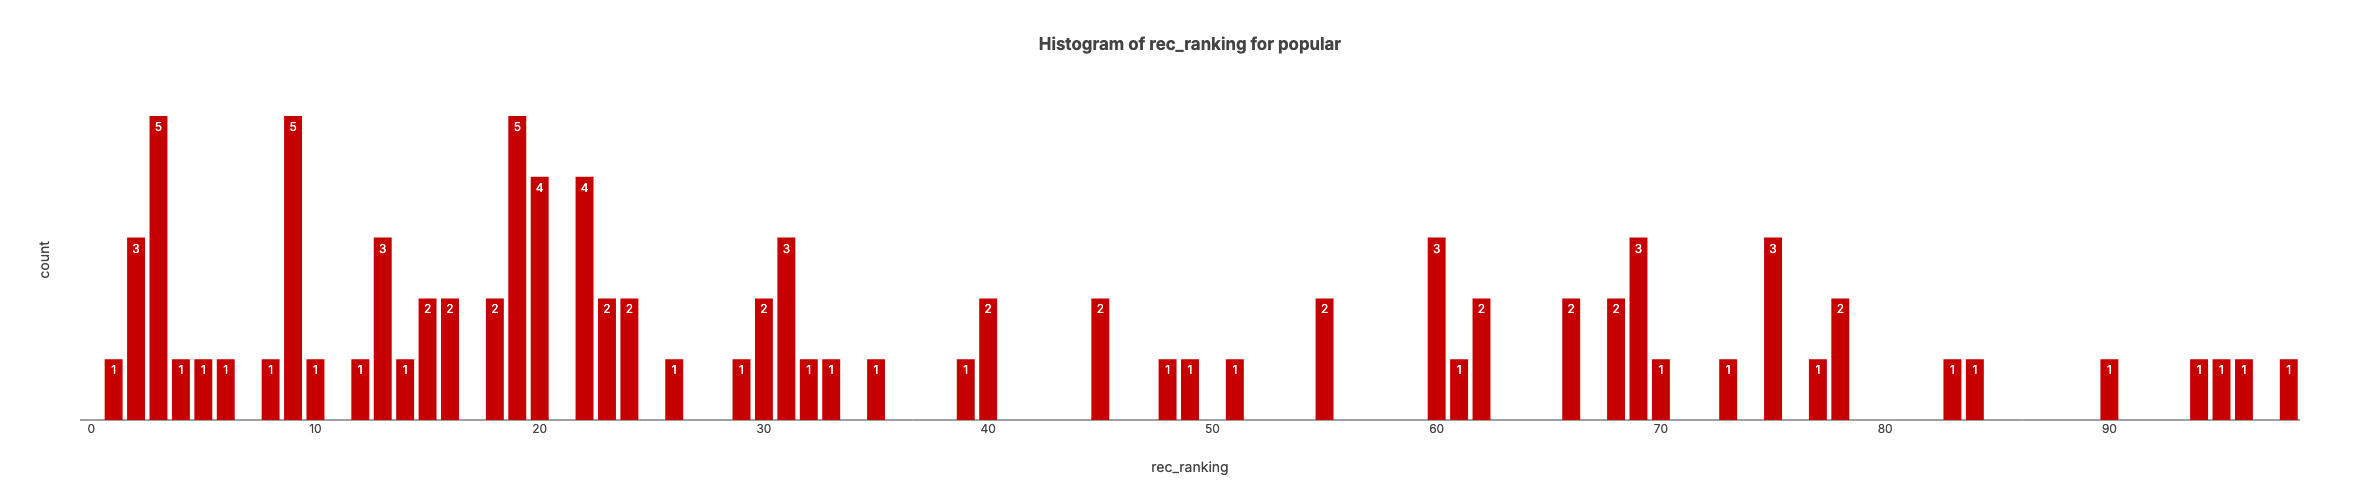

In [85]:
_df = popular_recs_target.loc[lambda df: df['rating_rank'].eq(1) & df['rec_ranking'].lt(101)]
plot_rec_ranking_histogram(_df, 'popular')

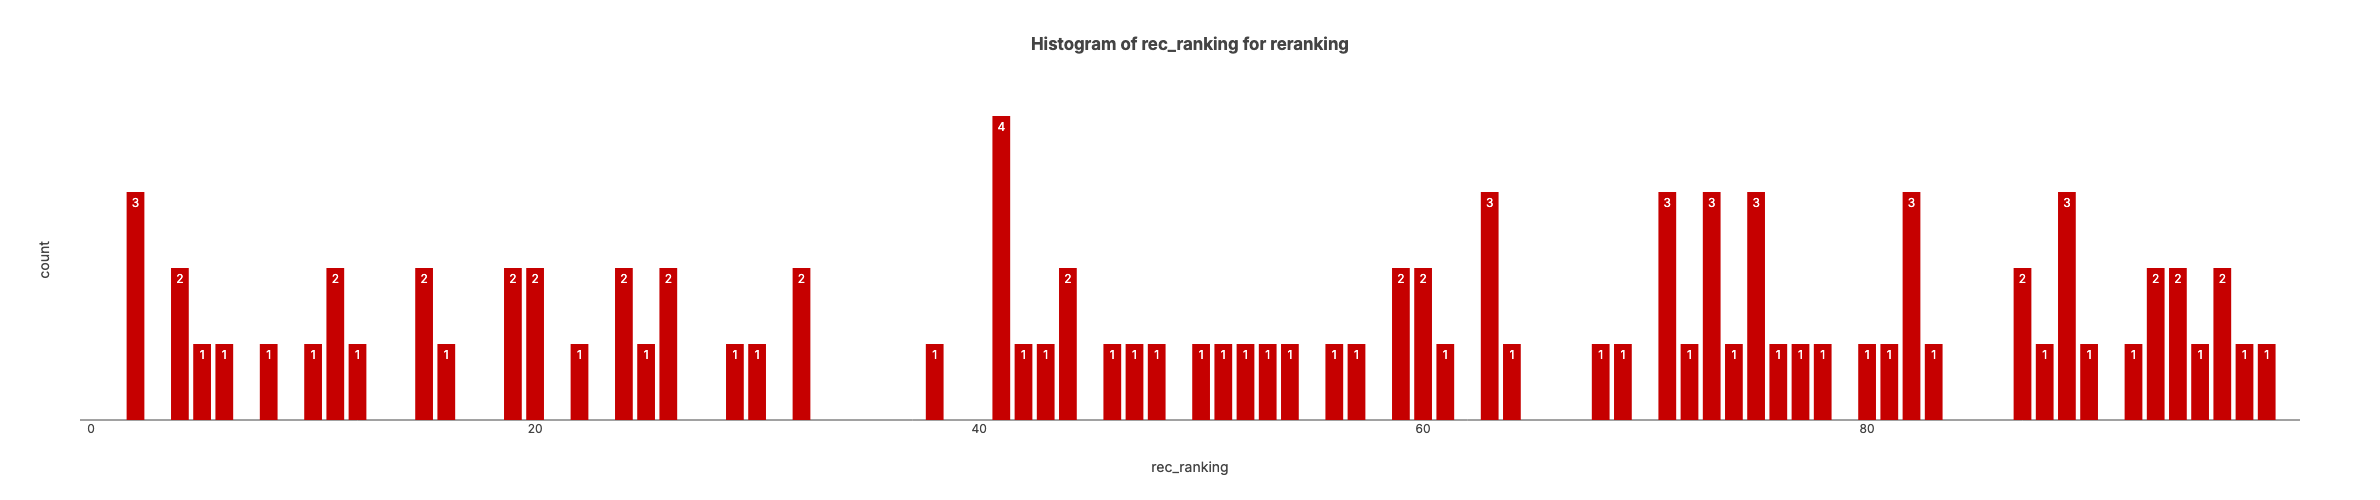

In [86]:
_df = reranking_recs_target.loc[lambda df: df['rating_rank'].eq(1) & df['rec_ranking'].lt(101)]
plot_rec_ranking_histogram(_df, 'reranking')

## Evaluate with Evidently

In [63]:
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import RecsysPreset
from evidently.metrics import PrecisionTopKMetric
from evidently.metrics import RecallTopKMetric
from evidently.metrics import FBetaTopKMetric
from evidently.metrics import MAPKMetric
from evidently.metrics import NDCGKMetric
from evidently.metrics import NoveltyMetric
from evidently.metrics import PersonalizationMetric
from evidently.metrics import HitRateKMetric
from evidently.metrics import MRRKMetric
from evidently.metrics import RecCasesTable

from src.features.eval.evidently.popularity_bias import PopularityBias

In [65]:
column_mapping = ColumnMapping(
    recommendations_type='rank',
    target='rating_rank',
    prediction='rec_ranking',
    item_id='parent_asin',
    user_id='user_id'
)

fighters = {
    'current': {
        'name': 'reranking',
        'recs': reranking_recs_target
    },
    'reference': {
        'name': 'popular',
        'recs': popular_recs_target
    }
}

report = Report(metrics=[
    NDCGKMetric(k=cmparams.top_k),
    RecallTopKMetric(k=cmparams.top_K),
    PrecisionTopKMetric(k=cmparams.top_k),
    FBetaTopKMetric(k=cmparams.top_k),
    MAPKMetric(k=cmparams.top_k),
    MRRKMetric(k=cmparams.top_k),
    NoveltyMetric(k=cmparams.top_k),
    PersonalizationMetric(k=cmparams.top_k),
    PopularityBias(k=cmparams.top_k),
    RecCasesTable(item_num=cmparams.top_k)
], options=[color_scheme])

log_time(printer=logger.info, method_name='generate_evidently_report')(report.run)(
    reference_data=fighters['reference']['recs'],
    current_data=fighters['current']['recs'],
    column_mapping=column_mapping,
    additional_data={'current_train_data': train_df}
)

evidently_report_fp = f"{args.notebook_persist_dp}/{fighters['current']['name']}_vs_{fighters['reference']['name']}_evidently_report.html"
os.makedirs(args.notebook_persist_dp, exist_ok=True)
report.save_html(evidently_report_fp)

if args.log_to_mlflow:
    mlflow.log_artifact(evidently_report_fp)

/home/dvquys/frostmourne/fsds/recsys/.venv/lib/python3.11/site-packages/evidently/metrics/recsys/precision_recall_k.py:55: FutureWarning: Support for axis=1 in DataFrame.expanding is deprecated and will be removed in a future version. Use obj.T.expanding(...) instead
  .expanding(axis=1)
/home/dvquys/frostmourne/fsds/recsys/.venv/lib/python3.11/site-packages/evidently/metrics/recsys/precision_recall_k.py:64: FutureWarning: Support for axis=1 in DataFrame.expanding is deprecated and will be removed in a future version. Use obj.T.expanding(...) instead
  .expanding(axis=1)
/home/dvquys/frostmourne/fsds/recsys/.venv/lib/python3.11/site-packages/evidently/metrics/recsys/precision_recall_k.py:75: FutureWarning: Support for axis=1 in DataFrame.expanding is deprecated and will be removed in a future version. Use obj.T.expanding(...) instead
  .expanding(axis=1)
/home/dvquys/frostmourne/fsds/recsys/.venv/lib/python3.11/site-packages/evidently/metrics/recsys/precision_recall_k.py:84: FutureWarn

# Clean up

In [35]:
from src.utils.io import list_files_in_folder

In [66]:
all_params = [args, train_args]

if args.log_to_mlflow:
    for params in all_params:
        params_dict = params.dict()
        params_ = {f"{params.__repr_name__()}.{k}": v for k, v in params_dict.items()}
        mlflow.log_params(params_)

In [67]:
mlflow.end_run()

2024/09/01 09:53:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run 002-ranking-first-attempt at: http://localhost:5002/#/experiments/3/runs/718c6d210f4046ba879766dcdcb115e6.
2024/09/01 09:53:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5002/#/experiments/3.
